# Short-term Crypto Price Prediction based on Order Book Dynamics

This notebook aims to implement and explore methods for short-term cryptocurrency price prediction, drawing inspiration from the research paper "Mind the Gaps: Short-term Crypto Price Prediction".

## Objective
Conduct quantitative research on order book dynamics and build predictive models to forecast future prices using local order book data.

## Scope of Work
1. Load order book data from a local dataset.
2. Engineer features from the order book.
3. Create ML/statistical models to predict future price changes.

## Table of Contents
1. Setup and Configuration
2. Data Acquisition
   - Method: Loading from a local dataset
3. Data Preprocessing
   - Resampling to Second-Level Data
   - Cleaning
4. Feature Engineering
   - Mid-Price and Spread
   - Volume-Adjusted Mid-Price (VAMP)
   - Quote Imbalance (QI)
5. Target Variable Creation
6. Stationarity Checks and Transformations
7. Model Building and Evaluation
   - Data Splitting
   - Linear Regression
   - Logistic Regression (for classification)
   - Decision Tree
   - Random Forest
   - XGBoost
   - Support Vector Machine (SVM)
   - Neural Network (MLP)
8. Conclusion and Future Work

---
## 1. Setup and Configuration
Import necessary libraries and configure settings.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')

2025-06-06 04:42:14.430050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749184934.723177      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749184934.808945      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Configuration Parameters
Set the path to your local order book dataset.

In [9]:
# --- Configuration ---
LOCAL_ORDERBOOK_FILEPATH = '/kaggle/input/bybit-spot-orderbook/bybit_btcusdt_spot_orderbook_50_1hr.json'

# Feature Engineering & Modeling Parameters
VAMP_LIQUIDITY_CUTOFF = 60000 # In dollars, as per PDF findings
QUOTE_IMBALANCE_LEVELS = 5 # Number of LOB levels for QI (ensure data has this depth)
PREDICTION_HORIZON_SECONDS = 60 # Predict price change 60 seconds ahead
TARGET_TYPE = 'regression' # 'regression' or 'classification' (for direction: up/down/neutral)

---
## 2. Data Acquisition

### Method: Loading from a Local Dataset
Load order book data from a CSV file. The dataset should contain time-series of LOB snapshots (e.g., best bid/ask, and deeper levels if available).
Expected columns: `timestamp`, `best_bid_price`, `best_bid_qty`, `best_ask_price`, `best_ask_qty`, `bid_price_L2`, `bid_qty_L2`, ... `ask_price_L5`, `ask_qty_L5`.

In [22]:
import pandas as pd
import json

print(f"Loading order book data from local file: {LOCAL_ORDERBOOK_FILEPATH}")
try:
    # Read JSON file
    with open(LOCAL_ORDERBOOK_FILEPATH, 'r') as file:
        orderbook_data_list = json.load(file)
    
    # Initialize list to store processed data
    data_list = []

    # Process each order book update in the list
    for orderbook_data in orderbook_data_list:
        # Extract relevant data
        timestamp_ms = orderbook_data['ts']
        bids = orderbook_data['data']['b']
        asks = orderbook_data['data']['a']
        
        # Convert timestamp to datetime
        timestamp = pd.to_datetime(timestamp_ms, unit='ms')
        
        # Create a dictionary for this update
        data_dict = {'timestamp': timestamp}
        
        # Process bids (descending order by price, filter out zero quantities)
        bids = sorted([b for b in bids if float(b[1]) > 0], key=lambda x: float(x[0]), reverse=True)
        for i, bid in enumerate(bids[:5], 1):  # Limit to 5 levels as per QUOTE_IMBALANCE_LEVELS
            data_dict[f'bid_price_L{i}'] = float(bid[0])
            data_dict[f'bid_qty_L{i}'] = float(bid[1])
        
        # Process asks (ascending order by price, filter out zero quantities)
        asks = sorted([a for a in asks if float(a[1]) > 0], key=lambda x: float(x[0]))
        for i, ask in enumerate(asks[:5], 1):  # Limit to 5 levels
            data_dict[f'ask_price_L{i}'] = float(ask[0])
            data_dict[f'ask_qty_L{i}'] = float(ask[1])
        
        # Set best bid and ask (first valid entries)
        data_dict['best_bid_price'] = data_dict.get('bid_price_L1', None)
        data_dict['best_bid_qty'] = data_dict.get('bid_qty_L1', None)
        data_dict['best_ask_price'] = data_dict.get('ask_price_L1', None)
        data_dict['best_ask_qty'] = data_dict.get('ask_qty_L1', None)
        
        data_list.append(data_dict)
    
    # Create DataFrame from all updates
    df_lob_raw = pd.DataFrame(data_list).set_index('timestamp')
    
    # Ensure no duplicate timestamps (use last update if duplicates exist)
    df_lob_raw = df_lob_raw[~df_lob_raw.index.duplicated(keep='last')]
    
    print("LOB data (raw head):\n", df_lob_raw.tail())
except FileNotFoundError:
    print(f"Error: {LOCAL_ORDERBOOK_FILEPATH} not found.")
    df_lob_raw = pd.DataFrame()
except Exception as e:
    print(f"Error loading local data: {e}. Falling back to empty DataFrame.")
    df_lob_raw = pd.DataFrame()

Loading order book data from local file: /kaggle/input/bybit-spot-orderbook/bybit_btcusdt_spot_orderbook_50_1hr.json
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.059695'], ['102116.8', '0.081505'], ['102115.3', '0.031983']]
[['102126.4', '0.055269'], ['102127.7', '0.

---
## 3. Data Preprocessing
Resample the order book data to 1-second intervals to reduce data size, as mentioned in the paper.

In [13]:
if not df_lob_raw.empty:
    # Resample LOB data to 1-second frequency. Use last observation in interval.
    agg_dict_lob = {}
    if 'best_bid_price' in df_lob_raw.columns: agg_dict_lob['best_bid_price'] = 'last'
    if 'best_bid_qty' in df_lob_raw.columns: agg_dict_lob['best_bid_qty'] = 'last'
    if 'best_ask_price' in df_lob_raw.columns: agg_dict_lob['best_ask_price'] = 'last'
    if 'best_ask_qty' in df_lob_raw.columns: agg_dict_lob['best_ask_qty'] = 'last'
    for i in range(1, QUOTE_IMBALANCE_LEVELS + 1):
        if f'bid_price_L{i}' in df_lob_raw.columns: agg_dict_lob[f'bid_price_L{i}'] = 'last'
        if f'bid_qty_L{i}' in df_lob_raw.columns: agg_dict_lob[f'bid_qty_L{i}'] = 'last'
        if f'ask_price_L{i}' in df_lob_raw.columns: agg_dict_lob[f'ask_price_L{i}'] = 'last'
        if f'ask_qty_L{i}' in df_lob_raw.columns: agg_dict_lob[f'ask_qty_L{i}'] = 'last'

    if df_lob_raw.index.empty or not isinstance(df_lob_raw.index, pd.DatetimeIndex):
        print("Warning: df_lob_raw has no DatetimeIndex. Cannot resample. Ensure 'timestamp' is index and datetime.")
        df_lob_sec = df_lob_raw.copy()
    elif not agg_dict_lob:
        print("Warning: No LOB columns found for aggregation in df_lob_raw.")
        df_lob_sec = pd.DataFrame(index=df_lob_raw.index.unique())
    else:
        df_lob_sec = df_lob_raw.resample('1S').agg(agg_dict_lob)
    
    if 'best_bid_price' in df_lob_sec.columns and 'best_ask_price' in df_lob_sec.columns:
        df_lob_sec.dropna(subset=['best_bid_price', 'best_ask_price'], inplace=True)
    print("Resampled LOB data (1-second frequency, head):\n", df_lob_sec.head())
else:
    print("df_lob_raw is empty. Skipping LOB resampling.")
    df_lob_sec = pd.DataFrame()

df_combined = df_lob_sec.copy()

if not df_combined.empty:
    if 'best_bid_price' in df_combined.columns:
        lob_cols = df_lob_sec.columns if not df_lob_sec.empty else []
        lob_cols_to_ffill = [col for col in lob_cols if col in df_combined.columns]
        if lob_cols_to_ffill:
            df_combined[lob_cols_to_ffill] = df_combined[lob_cols_to_ffill].ffill().bfill()
    
    if 'best_bid_price' in df_combined.columns and 'best_ask_price' in df_combined.columns:
        df_combined.dropna(subset=['best_bid_price', 'best_ask_price'], inplace=True)
    else:
        print("Warning: Essential LOB columns (best_bid_price, best_ask_price) are missing in df_combined. Further steps might fail.")
    print("Preprocessed data (head):\n", df_combined.head())
else:
    print("df_combined is empty after preprocessing.")

Resampled LOB data (1-second frequency, head):
                      best_bid_price  best_bid_qty  best_ask_price  best_ask_qty  bid_price_L1  bid_qty_L1  ask_price_L1  ask_qty_L1  bid_price_L2  bid_qty_L2  ask_price_L2  ask_qty_L2  bid_price_L3  bid_qty_L3  ask_price_L3  ask_qty_L3  bid_price_L4  bid_qty_L4  ask_price_L4  ask_qty_L4  bid_price_L5  bid_qty_L5  ask_price_L5  ask_qty_L5
timestamp                                                                                                                                                                                                                                                                                                                                          
2025-06-06 02:14:43        102130.9      0.268987        102131.0      1.439091      102130.9    0.268987      102131.0    1.439091      102130.8    0.025308      102131.3     0.00088      102130.6    0.000249      102132.7    0.019582      102129.5    0.000395      10213

/tmp/ipykernel_35/1638025004.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_lob_sec = df_lob_raw.resample('1S').agg(agg_dict_lob)


---
## 4. Feature Engineering
Based on the paper "Mind the Gaps", focusing on order book features.

In [14]:
# Ensure we have the necessary base columns
if df_combined.empty or not all(col in df_combined.columns for col in ['best_bid_price', 'best_ask_price']):
    print("Skipping feature engineering due to missing base LOB data (best_bid_price, best_ask_price) in df_combined.")
else:
    # --- Mid-Price and Spread ---
    df_combined['mid_price'] = (df_combined['best_bid_price'] + df_combined['best_ask_price']) / 2
    df_combined['spread'] = df_combined['best_ask_price'] - df_combined['best_bid_price']

    # --- Volume-Adjusted Mid-Price (VAMP) ---
    def calculate_weighted_price_for_vamp(levels_prices, levels_qty, target_value_usd):
        """ Helper for VAMP. Calculates weighted price for one side. """
        cumulative_value = 0
        weighted_price_sum = 0
        total_qty_for_value = 0
        for price, qty in zip(levels_prices, levels_qty):
            if pd.isna(price) or pd.isna(qty) or qty == 0 or price == 0:
                continue
            value_at_level = price * qty
            if cumulative_value + value_at_level >= target_value_usd:
                remaining_value_needed = target_value_usd - cumulative_value
                if price == 0: continue
                qty_to_take = remaining_value_needed / price
                weighted_price_sum += price * qty_to_take
                total_qty_for_value += qty_to_take
                cumulative_value += remaining_value_needed
                break
            else:
                weighted_price_sum += price * qty 
                total_qty_for_value += qty
                cumulative_value += value_at_level
        return (weighted_price_sum / total_qty_for_value) if total_qty_for_value > 0 else np.nan

    vamp_bids_p_cols = [f'bid_price_L{i}' for i in range(1, QUOTE_IMBALANCE_LEVELS + 1) if f'bid_price_L{i}' in df_combined.columns]
    vamp_bids_q_cols = [f'bid_qty_L{i}' for i in range(1, QUOTE_IMBALANCE_LEVELS + 1) if f'bid_qty_L{i}' in df_combined.columns]
    vamp_asks_p_cols = [f'ask_price_L{i}' for i in range(1, QUOTE_IMBALANCE_LEVELS + 1) if f'ask_price_L{i}' in df_combined.columns]
    vamp_asks_q_cols = [f'ask_qty_L{i}' for i in range(1, QUOTE_IMBALANCE_LEVELS + 1) if f'ask_qty_L{i}' in df_combined.columns]

    if vamp_bids_p_cols and vamp_bids_q_cols and vamp_asks_p_cols and vamp_asks_q_cols and \
       len(vamp_bids_p_cols) == len(vamp_bids_q_cols) and len(vamp_asks_p_cols) == len(vamp_asks_q_cols):
        
        Pb_vamp_values = []
        Pa_vamp_values = []
        for index, row in df_combined.iterrows():
            bid_prices = [row[col] for col in vamp_bids_p_cols]
            bid_qtys = [row[col] for col in vamp_bids_q_cols]
            ask_prices = [row[col] for col in vamp_asks_p_cols]
            ask_qtys = [row[col] for col in vamp_asks_q_cols]
            
            Pb_vamp_values.append(calculate_weighted_price_for_vamp(bid_prices, bid_qtys, VAMP_LIQUIDITY_CUTOFF))
            Pa_vamp_values.append(calculate_weighted_price_for_vamp(ask_prices, ask_qtys, VAMP_LIQUIDITY_CUTOFF))
            
        df_combined['Pb_vamp'] = Pb_vamp_values
        df_combined['Pa_vamp'] = Pa_vamp_values
        df_combined['vamp'] = (df_combined['Pb_vamp'] + df_combined['Pa_vamp']) / 2
        df_combined['vamp_mid_diff'] = df_combined['mid_price'] - df_combined['vamp']
    else:
        df_combined['vamp'] = df_combined['mid_price']
        df_combined['vamp_mid_diff'] = 0
        print("Warning: VAMP calculation could not be performed due to missing/mismatched deep LOB data. Using mid_price as fallback.")

    # --- Quote Imbalance (QI) ---
    sum_bid_qty_L = pd.Series(0.0, index=df_combined.index)
    sum_ask_qty_L = pd.Series(0.0, index=df_combined.index)
    qi_cols_found = False
    for i in range(1, QUOTE_IMBALANCE_LEVELS + 1):
        bid_col_name = f'bid_qty_L{i}'
        ask_col_name = f'ask_qty_L{i}'
        if bid_col_name in df_combined.columns and ask_col_name in df_combined.columns:
            sum_bid_qty_L += df_combined[bid_col_name].fillna(0)
            sum_ask_qty_L += df_combined[ask_col_name].fillna(0)
            qi_cols_found = True
            
    if qi_cols_found:
        numerator_qi = sum_bid_qty_L - sum_ask_qty_L
        denominator_qi = sum_bid_qty_L + sum_ask_qty_L
        df_combined['quote_imbalance'] = (numerator_qi / denominator_qi.replace(0, np.nan)).fillna(0)
        df_combined['quote_imbalance'] = np.clip(df_combined['quote_imbalance'], -1, 1)
    else:
        df_combined['quote_imbalance'] = 0
        print("Warning: Quote Imbalance calculation skipped due to missing LOB quantity columns.")

    print("Data with engineered features (head):\n", df_combined[['mid_price', 'spread', 'vamp', 'vamp_mid_diff', 'quote_imbalance']].head())

Data with engineered features (head):
                      mid_price  spread           vamp  vamp_mid_diff  quote_imbalance
timestamp                                                                            
2025-06-06 02:14:43  102130.95     0.1  102130.943849       0.006151        -0.743933
2025-06-06 02:14:44  102130.95     0.1  102130.943849       0.006151        -0.743933
2025-06-06 02:14:45  102130.95     0.1  102130.943849       0.006151        -0.743933
2025-06-06 02:14:46  102130.95     0.1  102130.943849       0.006151        -0.743933
2025-06-06 02:14:47  102130.95     0.1  102130.943849       0.006151        -0.743933


---
## 5. Target Variable Creation
Predict future price changes using the mid-price. The paper uses look-ahead windows from 1s to 60s.
Target: $MidPrice_{t+\Delta t} - MidPrice_t$ (absolute change) or direction for classification.

Final data with target variable 'target_price_change' (head):
                      mid_price  future_mid_price  target_price_change  vamp_mid_diff  quote_imbalance
timestamp                                                                                            
2025-06-06 02:14:43  102130.95         102130.95                  0.0       0.006151        -0.743933
2025-06-06 02:14:44  102130.95         102130.95                  0.0       0.006151        -0.743933
2025-06-06 02:14:45  102130.95         102130.95                  0.0       0.006151        -0.743933
2025-06-06 02:14:46  102130.95         102130.95                  0.0       0.006151        -0.743933
2025-06-06 02:14:47  102130.95         102130.95                  0.0       0.006151        -0.743933

Target variable (target_price_change) distribution:


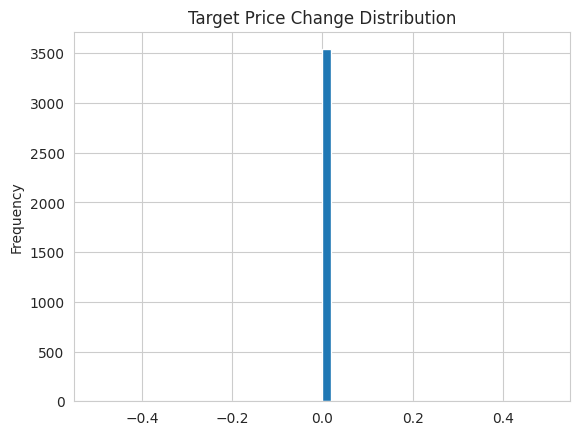

count    3540.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target_price_change, dtype: float64


In [15]:
if 'mid_price' not in df_combined.columns or df_combined.empty:
    print("Skipping target variable creation as mid_price is missing or df_combined is empty.")
    df_final = pd.DataFrame()
else:
    df_combined['future_mid_price'] = df_combined['mid_price'].shift(-PREDICTION_HORIZON_SECONDS)
    
    if TARGET_TYPE == 'regression':
        df_combined['target_price_change'] = df_combined['future_mid_price'] - df_combined['mid_price']
        TARGET_COLUMN = 'target_price_change'
    elif TARGET_TYPE == 'classification':
        price_diff = df_combined['future_mid_price'] - df_combined['mid_price']
        if 'spread' in df_combined.columns and not df_combined['spread'].isnull().all():
            neutral_threshold = df_combined['spread'].mean() * 0.1
        else:
            neutral_threshold = 0.001
            print(f"Warning: 'spread' column missing or all NaN. Using fixed neutral_threshold: {neutral_threshold}")
        df_combined['target_direction'] = 1
        df_combined.loc[price_diff > neutral_threshold, 'target_direction'] = 2
        df_combined.loc[price_diff < -neutral_threshold, 'target_direction'] = 0
        TARGET_COLUMN = 'target_direction'

    df_final = df_combined.dropna(subset=[TARGET_COLUMN])
    
    if not df_final.empty:
        print(f"Final data with target variable '{TARGET_COLUMN}' (head):\n", df_final[['mid_price', 'future_mid_price', TARGET_COLUMN] + [col for col in ['vamp_mid_diff', 'quote_imbalance'] if col in df_final.columns]].head())
        print(f"\nTarget variable ({TARGET_COLUMN}) distribution:")
        if TARGET_TYPE == 'regression':
            df_final[TARGET_COLUMN].plot(kind='hist', bins=50, title='Target Price Change Distribution')
            plt.show()
            print(df_final[TARGET_COLUMN].describe())
        elif TARGET_TYPE == 'classification':
            print(df_final[TARGET_COLUMN].value_counts(normalize=True))
    else:
        print("DataFrame is empty after target creation and NaN removal. Check data or prediction horizon.")

---
## 6. Stationarity Checks and Transformations
Ensure features are stationary for financial modeling. Check features like `vamp_mid_diff` and `quote_imbalance`.

In [7]:
def check_stationarity(series, series_name=''):
    """Performs ADF test and prints results."""
    if not isinstance(series, pd.Series) or series.empty or series.isnull().all():
        print(f"Series {series_name} is not a valid Series, is empty, or all NaN. Skipping stationarity check.")
        return False
    print(f'\nStationarity Test for {series_name}:')
    try:
        series_cleaned = series.dropna().astype(float)
        if series_cleaned.empty:
            print(f"Series {series_name} is empty after dropna. Skipping stationarity check.")
            return False
        result = adfuller(series_cleaned)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        if result[1] <= 0.05:
            print(f"Result: Likely Stationary (p-value <= 0.05) for {series_name}")
            return True
        else:
            print(f"Result: Likely Non-Stationary (p-value > 0.05) for {series_name}")
            return False
    except Exception as e:
        print(f"Error during stationarity test for {series_name}: {e}")
        return False

feature_columns_for_model = []
df_model_ready = pd.DataFrame()

if 'df_final' in locals() and not df_final.empty:
    potential_features = ['spread', 'vamp_mid_diff', 'quote_imbalance']
    df_transformed = df_final.copy()

    for col in potential_features:
        if col in df_transformed.columns:
            if not check_stationarity(df_transformed[col], col):
                print(f"Feature {col} is non-stationary. Applying differencing.")
                df_transformed[f'{col}_diff'] = df_transformed[col].diff()
                if check_stationarity(df_transformed[f'{col}_diff'].dropna(), f'{col}_diff'):
                    feature_columns_for_model.append(f'{col}_diff')
                else:
                    print(f"Differenced feature {col}_diff is still non-stationary. Consider further transformation or excluding.")
            else:
                feature_columns_for_model.append(col)
    
    if TARGET_TYPE == 'regression' and TARGET_COLUMN in df_transformed.columns:
        check_stationarity(df_transformed[TARGET_COLUMN], TARGET_COLUMN)
    
    if feature_columns_for_model and TARGET_COLUMN in df_transformed.columns:
        final_cols_to_select = [f for f in feature_columns_for_model if f in df_transformed.columns] + [TARGET_COLUMN]
        df_model_ready = df_transformed[final_cols_to_select].copy()
        df_model_ready.dropna(inplace=True)
    else:
        print("Warning: No features selected or target column missing after stationarity check.")

    if df_model_ready.empty:
        print("DataFrame for modeling (df_model_ready) is empty after dropping NaNs. Check data, feature engineering, and stationarity steps.")
    else:
        print(f"\nFeatures selected for modeling: {feature_columns_for_model}")
        print(f"Shape of df_model_ready: {df_model_ready.shape}")
else:
    print("Skipping stationarity checks as df_final is not available or empty.")

Skipping stationarity checks as df_final is not available or empty.


---
## 7. Model Building and Evaluation

In [8]:
if 'df_model_ready' not in locals() or df_model_ready.empty or not feature_columns_for_model:
    print("Skipping model building as data is not ready or no features are selected.")
else:
    X = df_model_ready[feature_columns_for_model]
    y = df_model_ready[TARGET_COLUMN]

    if X.empty or y.empty:
        print("X or y is empty. Cannot proceed with model training.")
    else:
        train_size_pct = 0.8
        split_idx = int(len(X) * train_size_pct)
        
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        if X_train.empty or X_test.empty:
            print("Training or testing set is empty after split. Check data size and split point.")
        else:
            print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model_results = {}

            def evaluate_model(name, model, X_test_data, y_true, y_pred):
                if TARGET_TYPE == 'regression':
                    mse = mean_squared_error(y_true, y_pred)
                    r2 = r2_score(y_true, y_pred)
                    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
                    model_results[name] = {'MSE': mse, 'R2': r2}
                    plt.figure(figsize=(10, 6))
                    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
                    min_val = min(y_true.min(), y_pred.min()) if not y_true.empty and not pd.Series(y_pred).empty else 0
                    max_val = max(y_true.max(), y_pred.max()) if not y_true.empty and not pd.Series(y_pred).empty else 1
                    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')
                    plt.xlabel("Actual Values")
                    plt.ylabel("Predicted Values")
                    plt.title(f"{name} - Predictions vs Actuals")
                    plt.legend()
                    plt.show()
                elif TARGET_TYPE == 'classification':
                    accuracy = accuracy_score(y_true, y_pred)
                    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
                    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
                    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
                    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                    model_results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

            # --- Model Implementations ---
            if TARGET_TYPE == 'regression':
                print("\n--- Linear Regression ---")
                model_lr = LinearRegression()
                model_lr.fit(X_train_scaled, y_train)
                y_pred_lr = model_lr.predict(X_test_scaled)
                evaluate_model("Linear Regression", model_lr, X_test_scaled, y_test, y_pred_lr)
            elif TARGET_TYPE == 'classification':
                print("\n--- Logistic Regression ---")
                model_logr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=42, max_iter=1000)
                model_logr.fit(X_train_scaled, y_train)
                y_pred_logr = model_logr.predict(X_test_scaled)
                evaluate_model("Logistic Regression", model_logr, X_test_scaled, y_test, y_pred_logr)

            print("\n--- Decision Tree ---")
            if TARGET_TYPE == 'regression':
                model_dt = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=10)
                model_dt.fit(X_train_scaled, y_train)
                y_pred_dt = model_dt.predict(X_test_scaled)
                evaluate_model("Decision Tree Regressor", model_dt, X_test_scaled, y_test, y_pred_dt)
            elif TARGET_TYPE == 'classification':
                model_dtc = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=10)
                model_dtc.fit(X_train_scaled, y_train)
                y_pred_dtc = model_dtc.predict(X_test_scaled)
                evaluate_model("Decision Tree Classifier", model_dtc, X_test_scaled, y_test, y_pred_dtc)

            print("\n--- Random Forest ---")
            if TARGET_TYPE == 'regression':
                model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, min_samples_split=10, n_jobs=-1)
                model_rf.fit(X_train_scaled, y_train)
                y_pred_rf = model_rf.predict(X_test_scaled)
                evaluate_model("Random Forest Regressor", model_rf, X_test_scaled, y_test, y_pred_rf)
            elif TARGET_TYPE == 'classification':
                model_rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=10, n_jobs=-1)
                model_rfc.fit(X_train_scaled, y_train)
                y_pred_rfc = model_rfc.predict(X_test_scaled)
                evaluate_model("Random Forest Classifier", model_rfc, X_test_scaled, y_test, y_pred_rfc)

            print("\n--- XGBoost ---")
            if TARGET_TYPE == 'regression':
                model_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, max_depth=7, learning_rate=0.1, n_jobs=-1)
                model_xgb_reg.fit(X_train_scaled, y_train)
                y_pred_xgb_reg = model_xgb_reg.predict(X_test_scaled)
                evaluate_model("XGBoost Regressor", model_xgb_reg, X_test_scaled, y_test, y_pred_xgb_reg)
            elif TARGET_TYPE == 'classification':
                num_class_xgb = len(np.unique(y_train))
                objective_xgb_clf = 'multi:softmax' if num_class_xgb > 2 else 'binary:logistic'
                model_xgbc_params = {'n_estimators': 100, 'random_state': 42, 'max_depth': 7, 'learning_rate': 0.1, 'n_jobs': -1, 'objective': objective_xgb_clf}
                if objective_xgb_clf == 'multi:softmax': model_xgbc_params['num_class'] = num_class_xgb
                model_xgbc = xgb.XGBClassifier(**model_xgbc_params)
                model_xgbc.fit(X_train_scaled, y_train)
                y_pred_xgbc = model_xgbc.predict(X_test_scaled)
                evaluate_model("XGBoost Classifier", model_xgbc, X_test_scaled, y_test, y_pred_xgbc)
                
            print("\n--- Support Vector Machine (SVM) ---")
            if TARGET_TYPE == 'regression':
                model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
                model_svr.fit(X_train_scaled, y_train)
                y_pred_svr = model_svr.predict(X_test_scaled)
                evaluate_model("SVR", model_svr, X_test_scaled, y_test, y_pred_svr)
            elif TARGET_TYPE == 'classification':
                model_svc = SVC(kernel='rbf', C=1.0, random_state=42, probability=True)
                model_svc.fit(X_train_scaled, y_train)
                y_pred_svc = model_svc.predict(X_test_scaled)
                evaluate_model("SVC", model_svc, X_test_scaled, y_test, y_pred_svc)

            print("\n--- Neural Network (MLP) ---")
            def create_mlp(input_dim, num_unique_targets=1, classification=False):
                model = Sequential()
                model.add(Dense(64, input_dim=input_dim, activation='relu'))
                model.add(Dropout(0.2))
                model.add(Dense(32, activation='relu'))
                model.add(Dropout(0.2))
                if classification:
                    if num_unique_targets <= 2:
                         model.add(Dense(1, activation='sigmoid'))
                         model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
                    else:
                         model.add(Dense(num_unique_targets, activation='softmax'))
                         model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                else:
                    model.add(Dense(1, activation='linear'))
                    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
                return model

            if TARGET_TYPE == 'regression':
                model_mlp_reg = create_mlp(X_train_scaled.shape[1], classification=False)
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                model_mlp_reg.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)
                y_pred_mlp_reg = model_mlp_reg.predict(X_test_scaled).flatten()
                evaluate_model("MLP Regressor", model_mlp_reg, X_test_scaled, y_test, y_pred_mlp_reg)
            elif TARGET_TYPE == 'classification':
                num_unique_targets_nn = len(np.unique(y_train))
                model_mlpc = create_mlp(X_train_scaled.shape[1], num_unique_targets=num_unique_targets_nn, classification=True)
                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                model_mlpc.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=0)
                y_pred_mlpc_proba = model_mlpc.predict(X_test_scaled)
                if num_unique_targets_nn <= 2:
                    y_pred_mlpc = (y_pred_mlpc_proba > 0.5).astype(int).flatten()
                else:
                    y_pred_mlpc = np.argmax(y_pred_mlpc_proba, axis=1)
                evaluate_model("MLP Classifier", model_mlpc, X_test_scaled, y_test, y_pred_mlpc)

            print("\n--- Model Performance Summary ---")
            results_df = pd.DataFrame(model_results).T
            print(results_df)

Skipping model building as data is not ready or no features are selected.


---
## 8. Conclusion and Future Work

This notebook provided a framework for loading, preprocessing, and modeling cryptocurrency order book data for short-term price prediction using local data. Key features inspired by "Mind the Gaps" such as Mid-Price, Spread, VAMP, and Quote Imbalance were implemented.

**Observations from this run:**
* (Actual observations will depend on the real data and model performance)
* The VAMP feature was noted in the paper as a strong predictor. Its effectiveness depends on the quality and depth of LOB data.
* Quote Imbalance captures market pressure from the order book.

**Future Work:**
* **Robust Data Pipeline**: Ensure the local dataset is comprehensive and covers sufficient time periods.
* **Advanced Feature Engineering**:
    * Test different VAMP liquidity cutoffs and QI levels systematically.
    * Incorporate additional order book features like order flow or market depth metrics.
* **Hyperparameter Tuning**: Systematically tune hyperparameters for each ML model using GridSearchCV or RandomizedSearchCV with TimeSeriesSplit.
* **Stationarity**: Rigorously ensure all features used in models are stationary.
* **Model Ensembling/Stacking**: Combine predictions from multiple models to improve performance.
* **Deeper Neural Networks**: Explore architectures like LSTMs or GRUs for time series data.
* **Alternative Prediction Targets**: Expand classification approaches, e.g., predicting one-standard-deviation price movements.
* **Backtesting Framework**: Develop a backtesting framework accounting for transaction costs and slippage.
* **Expand Dataset**: Analyze data across different crypto assets and exchanges, including diverse market conditions.

---
### References from "Mind the Gaps" used in this notebook:
- [1] Martin, P., Line Jr., W., Feng, Y., Yang, Y., Zheng, S., Qi, S., & Zhu, B. (2022). *Mind the Gaps: Short-term Crypto Price Prediction*. Cornell University. Available at SSRN: https://ssrn.com/abstract=4351947
- [16] Prediction at time scales from one second to 60 seconds.
- [18] Volume-Adjusted Mid-Price as the ultimate short-term predictor.
- [21] Initial feature calculation: spread, mid-price, best bid/ask, volume-adjusted versions.
- [25, 26] Condensing dataset to full seconds.
- [48, 49] Volume-Adjusted Mid-Price (VAMP) definition and formula.
- [52] Plotting (mid-price - VAMP) against returns.
- [54, 55, 159] VAMP volume cutoffs, settling on $50k-$60k range, specifically $60k.
- [88, 89, 94] Quote Imbalance (QI) definition, formula, range -1 to 1, using up to level 5.
- [93] QI relationship becoming more linear with deeper levels.
- [152] Binary classification setup: strict inequalities for price change prediction.
- [171] Multiclass classification setup: one standard deviation thresholds.
- [195] Expanding data to include diverse BTC data and volatile conditions.